In [1]:
!pip install -U pip uv
!uv pip install -U matplotlib numpy ipympl
!uv pip install -U "jax[cuda]" tensorboard tensorboard-plugin-profile optax flax torchvision torch --index-url https://download.pytorch.org/whl/cpu

#%load_ext matplotlib
#%matplotlib widget

Using Python 3.12.3 environment at: /home/rdyro_google_com/venv
Resolved 32 packages in 97ms                                         
Prepared 1 package in 0.34ms                                             
Uninstalled 2 packages in 4ms
Installed 1 package in 11ms                                 
 - ipython==9.1.0
 ~ ipython==9.2.0
Using Python 3.12.3 environment at: /home/rdyro_google_com/venv
Resolved 93 packages in 698ms                                        
Audited 93 packages in 0.07ms


In [2]:
import os
from functools import partial
from pathlib import Path

# no GPU VRAM preallocation can hurt efficiency, but lets us observe VRAM usage
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"  

import jax
from jax import numpy as jnp
from jax import random
from jax.sharding import PartitionSpec as P, NamedSharding
import optax
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np

# What is JAX

In [3]:
def add(a, b):
  return a + jnp.sin(b)

add(jnp.ones(1), 2 * jnp.ones(1))  # like numpy

Array([1.9092975], dtype=float32)

# How JAX transformations works

In [4]:
def linear_model(A, x, y):
  return jnp.mean((jnp.tanh(x @ A) - y) ** 2)

In [5]:
keys = iter(random.split(jax.random.key(17), 1024))
x = random.normal(next(keys), (1024,))
A = random.normal(next(keys), (1024, 16)) / 1024
y = random.normal(next(keys), (16,))
print(linear_model(A, x, y))

0.8588184


In [6]:
%timeit -n 100 -r 10 linear_model(A, x, y).block_until_ready()
# first time call will complain about high variance in timing, first call compiles the function
# rerun the cell
%timeit -n 100 -r 10 jax.jit(linear_model)(A, x, y).block_until_ready()

446 μs ± 5.69 μs per loop (mean ± std. dev. of 10 runs, 100 loops each)
The slowest run took 5.96 times longer than the fastest. This could mean that an intermediate result is being cached.
356 μs ± 332 μs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [7]:
jit_fn = jax.jit(linear_model)
jit_fn(A, x, y)
# or simply
jax.jit(linear_model)(A, x, y)  # this jit is cached

Array(0.8588184, dtype=float32)

In [8]:
dA = jax.grad(linear_model)(A, x, y)
dx, dy = jax.grad(linear_model, argnums=(1, 2))(A, x, y)  # provide argnums to get grad wrt non-0 argument

In [9]:
jax.jit(jax.hessian(linear_model, argnums=2))(A, x, y)  # higher order derivatives very fast with JIT

Array([[0.125, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.125, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.125, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.125, 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.125, 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.125, 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.125, 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.125, 0.   ,
        0.   , 0.   , 0.  

In [10]:
# jaxpr are unoptimized jax programs intermediate representation
print(jax.make_jaxpr(lambda x: x ** 2)(1))
print("-------------------------------------")
# grad is just a transformation of the program
print(jax.make_jaxpr(jax.grad(lambda x: x ** 2))(1.0))

{ lambda ; a:i32[]. let b:i32[] = integer_pow[y=2] a in (b,) }
-------------------------------------
{ lambda ; a:f32[]. let
    _:f32[] = integer_pow[y=2] a
    b:f32[] = integer_pow[y=1] a
    c:f32[] = mul 2.0 b
    d:f32[] = mul 1.0 c
  in (d,) }


In [11]:
X = jax.random.normal(next(keys), (128, 1024))
Y = jax.random.normal(next(keys), (128, 16))

In [12]:
# in_axes=(
#   None,   # broadcast first argument
#   0,      # batch over the first axis
#   0       # batch over the first axis
# )
jax.vmap(linear_model, in_axes=(None, 0, 0))(A, X, Y).shape
# 128 losses

(128,)

### Working with pytrees

JAX uses pytrees to map over arbitrarily nested containers.

* `jax.tree.map` - applies a transformation to data
* `jax.tree.leaves` - flattens all data into a list
* `jax.tree.structure` - gives you the pytree structure without data
* `jax.tree.flatten` - outputs a tuple of struct and flat list of leaves
* `jax.tree.unflatten` - combines a pytree structure and a flat list of leaves

Most functions accept pytrees!

In [13]:
model = {
    "layer_embed": jnp.ones((2, 2)),
    "layers": [1, 2, 3, jnp.ones(2)],
    "names": ["model", ("alternative", "names")]
}

model

{'layer_embed': Array([[1., 1.],
        [1., 1.]], dtype=float32),
 'layers': [1, 2, 3, Array([1., 1.], dtype=float32)],
 'names': ['model', ('alternative', 'names')]}

In [14]:
jax.tree.leaves(model)

[Array([[1., 1.],
        [1., 1.]], dtype=float32),
 1,
 2,
 3,
 Array([1., 1.], dtype=float32),
 'model',
 'alternative',
 'names']

In [15]:
jax.tree.structure(model)

PyTreeDef({'layer_embed': *, 'layers': [*, *, *, *], 'names': [*, (*, *)]})

In [16]:
jax.tree.map(lambda x: None, model)

{'layer_embed': None,
 'layers': [None, None, None, None],
 'names': [None, (None, None)]}

# Neural Networks with NNX

| Framework   | Origin      | Key Characteristics             | Status / Notes                                   |
|-------------|-------------|---------------------------------|--------------------------------------------------|
| haiku       | from GDM    | Early JAX NN library            | **Deprecated**                                   |
| equinox     | third party | Simple and powerful stateful/functional library | Has a lot of fans, treat all models and modules as pytrees  |
| flax.linen  | from GDM    | Original `flax` interface | In active use, useful for some applications      |
| flax.nnx    | from GDM    | New stateful `flax` interface     | Supports model surgery, **Recommended for new projects**, Stateful modules similar to PyTorch |

In [17]:
from flax import nnx

class Model(nnx.Module):
  def __init__(self, *, rngs: nnx.Rngs):
    self.embed = nnx.Linear(1, 128, rngs=rngs)
    self.ws = [nnx.Linear(128, 128, rngs=rngs) for _ in range(16)]
    self.out_project = nnx.Linear(128, 1, rngs=rngs)
    
  def __call__(self, x):
    z = jax.nn.relu(self.embed(x))
    for w in self.ws:
      z = jax.nn.relu(w(z))
    return self.out_project(z)

In [18]:
rngs = nnx.Rngs(0)  # we need a random key generator for deterministic randomness
model = Model(rngs=nnx.Rngs(0))  # model initialized like a Python class (it is a Python object)
graphdef, state = nnx.split(model)  # split the model into its (graph) definition and its JAX state

In [19]:
# you can modify model in place, perform surgery
print(model.embed.kernel.value)
model.embed.kernel.value *= 2
print(model.embed.kernel.value)

# need to split into state again
graphdef, state = nnx.split(model)
# or just get the state
state = nnx.state(model)

[[ 1.0701778  -0.9697271  -0.80445254 -1.2385126  -0.9333001   0.63547826
   0.77888346 -1.0921763   1.687579   -1.8619802  -1.3531601   0.14494109
  -1.2203475   0.25944272  1.754148    0.54584336  0.6421062  -0.5113206
   0.9793505   0.39117435 -0.68375415 -0.93252856  0.81521004  1.1299591
   0.9718173  -0.5322273   0.95122933  1.674182   -2.1652231   0.47795188
   1.8091652  -1.2402649  -0.6353485   2.0182462   0.8608911  -0.21413715
  -1.7502464  -0.8813473  -2.1150775   1.5953505   1.4630404   0.3794973
   0.06777589  1.2143842  -0.23038422 -0.3679456   0.7417922  -0.36747482
   0.53188926  0.22945221 -1.8056844   1.857207    0.90616226  1.7088882
   1.6748439  -0.8291112   1.2752287  -1.0365843   1.1381445  -0.19218571
   0.9254915   0.43859228 -0.6696252   0.24980658 -2.1557667  -0.7694132
  -0.2032781   2.1232479  -1.7933295  -1.1030672  -1.3330144  -1.5496525
   0.09246044  1.7974176   1.3423549   0.5320915   0.5720489   0.74400496
   0.90918857 -0.13917612 -0.72048926  1.539

In [20]:
model_size = jax.tree.reduce(         # reduce to add all byte sizes
  lambda x, y: x + y,
  jax.tree.map(                       #  map to get byte size of each leaf
    lambda x: x.itemsize * x.size,
    state)
)
print(f"Model size = {model_size / 1e6} MB")

Model size = 1.058308 MB


In [ ]:
# state is a pytree
state

In [ ]:
# graphdef is the model skeleton
graphdef

In [23]:
@jax.jit
def forward(state, x):
  model = nnx.merge(graphdef, state) # merge the model graph and the model state
  return model(x)
  
@jax.jit
def loss_fn(state, x, y):
  yp = forward(state, x)
  return jnp.mean(jnp.linalg.norm(y - yp, axis=-1) ** 2)

grad_fn = jax.jit(jax.grad(loss_fn, argnums=0))

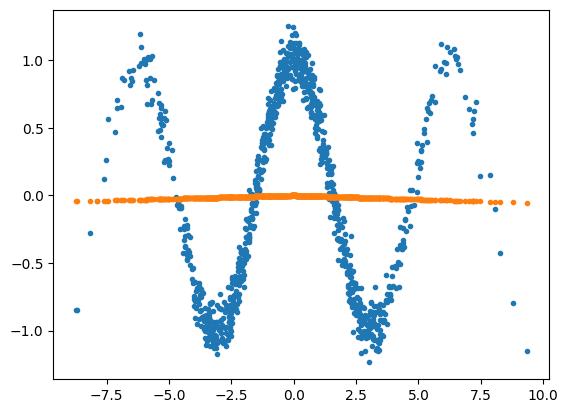

In [24]:
# synthetic data with most points concentrated in the middle

X = 3e0 * random.normal(rngs(), (1024, 1))
Y = jnp.cos(X) + 1e-1 * random.normal(rngs(), X.shape)

plt.figure()
plt.scatter(X[..., 0], Y[..., 0], marker=".")
Yp = forward(state, X)
plt.scatter(X[..., 0], Yp[..., 0], marker=".")

In [25]:
optimizer = optax.adam(1e-5)

@jax.jit # want to compile the top level function
def train_step(x, y, state, opt_state):
  loss = loss_fn(state, x, y)
  gs = jax.grad(loss_fn, argnums=0)(state, x, y) # recomputation, but ok, compiler will merge it
  updates, opt_state = optimizer.update(gs, opt_state)
  new_state = optax.apply_updates(state, updates)
  return loss, new_state, opt_state

state = nnx.state(model)
opt_state = optimizer.init(state)

pbar = tqdm(range(int(4e3)))
for _ in pbar:
  ridx = random.randint(rngs(), (64,), 0, X.shape[0])
  x, y = X[ridx, :], Y[ridx, :]
  l, state, opt_state = train_step(x, y, state, opt_state)
  pbar.set_description(f"loss = {l:.4e}")

loss = 1.6381e-02: 100%|██████████| 4000/4000 [00:24<00:00, 161.29it/s]


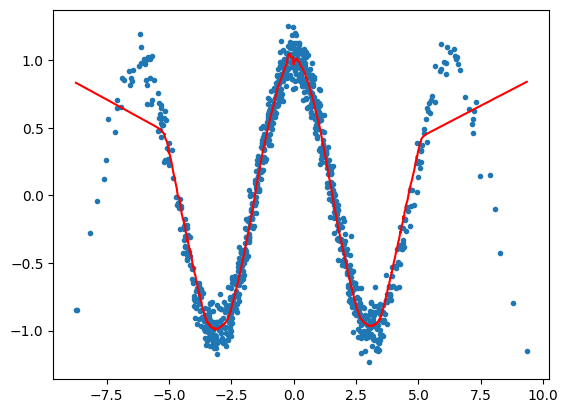

In [26]:
X_sort = jnp.sort(X, axis=0)
Yp_sort = forward(state, X_sort)
plt.figure()
plt.plot(X_sort[:, 0], Yp_sort[:, 0], color="red")
plt.scatter(X[:, 0], Y[:, 0], marker=".")

In [27]:
# static argnuments are non-numeric or for Python control flow
# must be declared explicitly because JAX is trying to compile as much as possible
@partial(jax.jit, static_argnames=("loss_fn",)) 
def train_step(x, y, state, opt_state, loss_fn=None):
  loss = loss_fn(state, x, y)
  gs = jax.grad(loss_fn, argnums=0)(state, x, y) # recomputation, but ok, compiler will merge it
  updates, opt_state = optimizer.update(gs, opt_state)
  new_state = optax.apply_updates(state, updates)
  return loss, new_state, opt_state

In [28]:
@jax.jit
def weighted_loss_fn(state, x, y):
  yp = forward(state, x)
  per_example_loss = jnp.sum((y - yp) ** 2, axis=-1)
  return jnp.mean(1e1 * jnp.abs(x[..., 0]) * per_example_loss) # weigh examples farther from zero more

pbar = tqdm(range(int(4e3)))
for _ in pbar:
  ridx = random.randint(rngs(), (64,), 0, X.shape[0])
  x, y = X[ridx, :], Y[ridx, :]
  l, state, opt_state = train_step(x, y, state, opt_state, loss_fn=weighted_loss_fn)
  pbar.set_description(f"loss = {l:.4e}")

loss = 1.7664e+00: 100%|██████████| 4000/4000 [00:23<00:00, 172.86it/s]


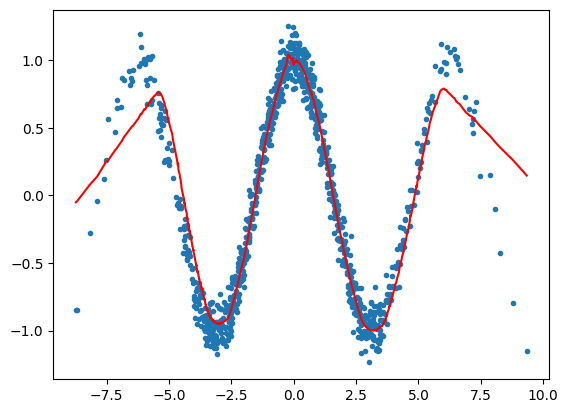

In [29]:
X_sort = jnp.sort(X, axis=0)
Yp_sort = forward(state, X_sort)
plt.figure()
plt.plot(X_sort[:, 0], Yp_sort[:, 0], color="red")
plt.scatter(X[:, 0], Y[:, 0], marker=".")

# Robotics + RL

### Loop unrolling and JAX control flow

In [ ]:
# calling train step from eager mode can have a small overhead (~1-5 ms on GPUs, less on other platforms)

# we can unroll the training loop
@partial(jax.jit, static_argnames=("steps", "loss_fn",))
def train_n_steps(x, y, state, opt_state, steps, loss_fn=None):
  # steps is a static variable

  loss_history = []
  for i in range(steps):  # unroll the loop inside the jitted function
    x_, y_ = x[i, ...], y[i, ...]
    loss, state, opt_state = train_step(x_, y_, state, opt_state, loss_fn=loss_fn)
    loss_history.append(loss)

  return jnp.stack(loss_history), state, opt_state

In [37]:
state = nnx.state(Model(rngs=rngs))
opt_state = optimizer.init(state)

pbar = tqdm(range(int(50)))
steps = 3
for _ in pbar:
  ridx = random.randint(rngs(), (steps * 64,), 0, X.shape[0])
  x, y = X[ridx, :], Y[ridx, :]
  x, y = x.reshape((steps, 64, 1)), y.reshape((steps, 64, 1))
  l, state, opt_state = train_n_steps(x, y, state, opt_state, steps=steps, loss_fn=loss_fn)
  pbar.set_description(f"losses = {l[-1]:.4e}")
  
  # each iteration is actually 3 iterations

losses = 4.8804e-01:   0%|          | 0/50 [00:00<?, ?it/s]

losses = 5.5561e-01: 100%|██████████| 50/50 [00:00<00:00, 153.63it/s]


In [38]:
# we can unroll the training loop
@partial(jax.jit, static_argnames=("loss_fn",))
def train_n_steps(x, y, state, opt_state, steps, loss_fn=None):
  # steps no longer needs to be a static variable

  def loop_body(i, carry):
    loss_history, state, opt_state = carry
    x_ = jax.lax.dynamic_index_in_dim(x, i, axis=0)  # single batch from a stack of batches
    y_ = jax.lax.dynamic_index_in_dim(y, i, axis=0)  # single batch from a stack of batches
    loss, state, opt_state = train_step(x_, y_, state, opt_state, loss_fn=loss_fn)
    loss_history = jax.lax.dynamic_update_index_in_dim(loss_history, loss, i, axis=0)
    return loss_history, state, opt_state
    
  loss_history = jnp.zeros((1024,))  # overallocate
  loss_history, state, opt_state = jax.lax.fori_loop(0, steps, loop_body, (loss_history, state, opt_state))
  return loss_history, state, opt_state

In [39]:
state = nnx.state(Model(rngs=rngs))
opt_state = optimizer.init(state)

pbar = tqdm(range(int(50)))
steps = 100
for _ in pbar:
  ridx = random.randint(rngs(), (steps * 64,), 0, X.shape[0])
  x, y = X[ridx, :], Y[ridx, :]
  x, y = x.reshape((steps, 64, 1)), y.reshape((steps, 64, 1))
  l, state, opt_state = train_n_steps(x, y, state, opt_state, steps=steps, loss_fn=loss_fn)
  pbar.set_description(f"losses = {l[-1]:.4e}")
  
  # each iteration is actually 100 iterations

  0%|          | 0/50 [00:00<?, ?it/s]

losses = 0.0000e+00: 100%|██████████| 50/50 [00:03<00:00, 13.29it/s]


### What about a dynamic iteration count?

In [40]:
# train for n steps or until you encounter a nan loss

@partial(jax.jit, static_argnames=("loss_fn",))
def train_n_steps_maybe_stop_early(x, y, state, opt_state, steps, loss_fn=None):
  # steps no longer needs to be a static variable

  def loop_body(i, carry):
    loss_history, state, opt_state, done = carry
    x_ = jax.lax.dynamic_index_in_dim(x, i, axis=0)
    y_ = jax.lax.dynamic_index_in_dim(y, i, axis=0)
    loss, state, opt_state = train_step(x_, y_, state, opt_state, loss_fn=loss_fn)
    loss_history = jax.lax.dynamic_update_index_in_dim(loss_history, loss, i, axis=0)

    done = done | jnp.isnan(loss)  # update the done state

    return loss_history, state, opt_state, done

  def lazy_loop_body(i, carry):
    done = carry[-1]
    new_carry = jax.lax.cond(done, 
                             lambda: carry,
                             lambda: loop_body(i, carry))
    return new_carry

  loss_history = jnp.zeros((1024,))  # cannot use steps, need to overallocate
  done = False
  init_val = (loss_history, state, opt_state, done)
  steps = (2 ** jnp.ceil(jnp.log2(steps))).astype(jnp.int32)  # just for fun, use an even power of 2 iterations
  loss_history, state, opt_state, done = jax.lax.fori_loop(0, steps, lazy_loop_body, init_val)
  return loss_history, state, opt_state

In [41]:
state = nnx.state(Model(rngs=rngs))
opt_state = optimizer.init(state)

pbar = tqdm(range(int(50)))
steps = 100
for _ in pbar:
  ridx = random.randint(rngs(), (steps * 64,), 0, X.shape[0])
  x, y = X[ridx, :], Y[ridx, :]
  x, y = x.reshape((steps, 64, 1)), y.reshape((steps, 64, 1))
  l, state, opt_state = train_n_steps_maybe_stop_early(x, y, state, opt_state, steps=steps, loss_fn=loss_fn)
  pbar.set_description(f"losses = {l[-1]:.4e}")

  0%|          | 0/50 [00:00<?, ?it/s]

losses = 0.0000e+00: 100%|██████████| 50/50 [00:05<00:00,  9.40it/s]


### JAX control flow

### [https://docs.jax.dev/en/latest/control-flow.html](https://docs.jax.dev/en/latest/control-flow.html)

<!--<img src="images/jax_control_flow.png" style="max-width:800px">-->

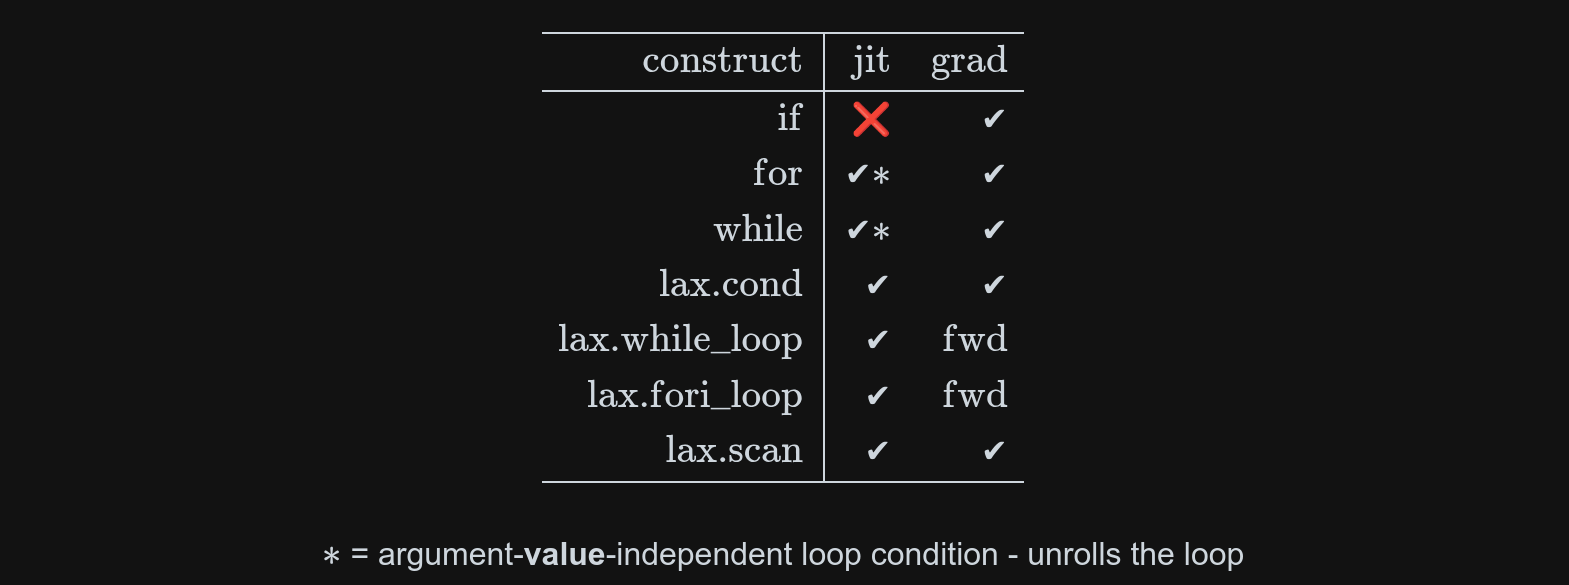

# Train on actual data

In [42]:
from torchvision import datasets
from torch.utils.data import DataLoader  # use torch dataloader to set up data

def collate_fn(data):
  return np.stack([arg[0] for arg in data]), np.array([arg[1] for arg in data])

ds = datasets.MNIST(".", download=True)
dl = DataLoader([(np.array(image), cls) for image, cls in tqdm(ds)], 128, shuffle=True, collate_fn=collate_fn, drop_last=True)

100%|██████████| 60000/60000 [00:02<00:00, 26623.05it/s]


In [43]:
class MNISTModel(nnx.Module):
  def __init__(self, *, rngs: nnx.Rngs):
    channels = 128
    self.conv0 = nnx.Conv(1, channels, (3, 3), rngs=rngs)
    self.convs = [nnx.Conv(channels, channels, (3, 3), rngs=rngs) for _ in range(32)]
    self.output = nnx.Linear(channels * 28 * 28, 1024, rngs=rngs)
    self.classifier = nnx.Linear(1024, 10, rngs=rngs)
    
  def __call__(self, x):
    x = x if x.ndim == 4 else x[..., None]
    z = jax.nn.relu(self.conv0(x))
    for conv in self.convs:
      z = z + jax.nn.relu(conv(z))
    z = z.reshape((z.shape[0], -1))
    self.sow(nnx.Intermediate, "x_flat", z)  # if you want to save some values
    z = jax.nn.relu(self.output(z))
    return self.classifier(z)

In [44]:
rngs = nnx.Rngs(0)  # create random keys generator
model = MNISTModel(rngs=rngs)

In [ ]:
# get intermediate value by filtering out intermediate state
# nnx.split and nnx.state take additional filter arguments
# these filter out variable types
# - nnx.Param
# - nnx.BatchStat
# - nnx.Intermediate

imgs, classes = next(iter(dl))
_ = model(imgs)
x_flat = nnx.state(model, nnx.Intermediate).x_flat.value[0]  # filter out only nnx.Intermediate variables
print(x_flat.shape)

(128, 100352)


In [46]:
model = MNISTModel(rngs=rngs)
graphdef, state = nnx.split(model)
jax.sharding.set_mesh(jax.make_mesh((1,), ("data",)))
state = jax.device_put(state, P())
optimizer = optax.adam(1e-4)
opt_state = optimizer.init(state)

@jax.jit
def train_step(imgs, y, state, opt_state):

  def loss_fn(state):
    model = nnx.merge(graphdef, state)
    yp = model(imgs)
    return jnp.mean(optax.softmax_cross_entropy_with_integer_labels(yp, y))
    
  with jax.named_scope("forward"):
    loss = loss_fn(state)
  with jax.named_scope("backward"):
    gs = jax.grad(loss_fn)(state)
  pred = nnx.merge(graphdef, state)(imgs)
  updates, opt_state = optimizer.update(gs, opt_state)
  state = optax.apply_updates(state, updates)
  return loss, pred, state, opt_state

  0%|          | 0/200 [00:00<?, ?it/s]

loss = 2.2356e+02, accuracy 57.777691%: : 201it [00:20,  9.84it/s]                       


Text(0.5, 0, 'Iteration')

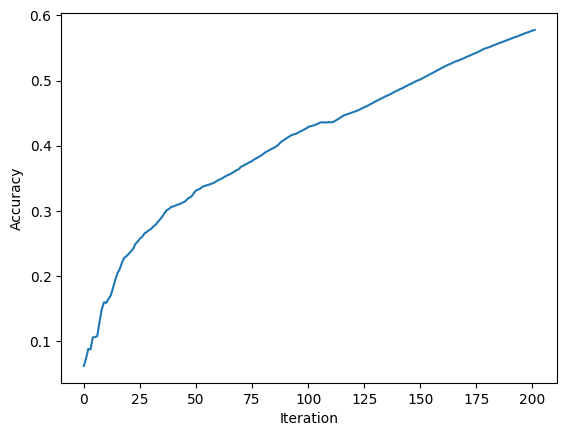

In [47]:
losses = []
max_it = int(2e2)
pbar = tqdm(enumerate(dl), total=max_it)
total, correct = 0, 0
train_accuracies = []
_ = train_step(imgs, classes, state, opt_state) # precompile train step
for i, (imgs, classes) in pbar:
  loss, pred, state, opt_state = train_step(imgs, classes, state, opt_state)
  losses.append(loss)
  total, correct = total + imgs.shape[0], correct + jnp.sum(jnp.argmax(pred, -1) == classes)
  train_accuracies.append(correct / total)
  pbar.set_description(f"{loss = :.4e}, accuracy {correct / total:%}")
  if i > max_it:
    break
model = nnx.merge(graphdef, state)  # merge model to insert the optimized state

plt.figure()
plt.plot(train_accuracies)
plt.ylabel("Accuracy")
plt.xlabel("Iteration")

# Profiling and Optimization

In [48]:
model = MNISTModel(rngs=rngs)
graphdef, state = nnx.split(model)
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(state)
with jax.profiler.trace(Path("~/profiles").expanduser()):
  for _ in range(10):
    loss, pred, state, opt_state = train_step(imgs, classes, state, opt_state)
    
# use tensorboard from command line or install tensorboard VSCode extension
# profile is at ~/profiles

2025-04-25 21:05:36.714038: E external/xla/xla/python/profiler/internal/python_hooks.cc:412] Can't import tensorflow.python.profiler.trace
2025-04-25 21:05:37.266895: E external/xla/xla/python/profiler/internal/python_hooks.cc:412] Can't import tensorflow.python.profiler.trace


# Unified sharding API (Data / Tensor / Pipeline parallelism)

In [49]:
print(jax.devices())

[CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]


In [50]:
from jax.sharding import PartitionSpec as P, use_mesh, set_mesh

A = jnp.ones((16, 16))
# a simple mesh with one axis called "data" - name is completely arbitrary
mesh = jax.make_mesh((jax.device_count(),), ("data",))
set_mesh(mesh)  # set the mesh globally

A = jax.device_put(A, P("data", None))
jax.debug.visualize_array_sharding(A)

                         
          GPU 0          
                         
                         
          GPU 1          
                         
                         
          GPU 2          
                         
                         
          GPU 3          
                         

In [51]:
A = jax.device_put(A, P("data", "data"))  # cannot shard both axis

DuplicateSpecError: A single NamedSharding spec specification can map every mesh axis to at most one positional dimension, but PartitionSpec('data', 'data') has duplicate entries for `data`

In [52]:
A = jax.device_put(jnp.ones((3, 4)), P("data", None))  # cannot shard both axis

ValueError: One of device_put args was given the sharding of NamedSharding(mesh=Mesh('data': 4, axis_types=(Auto,)), spec=PartitionSpec('data', None), memory_kind=device), which implies that the global size of its dimension 0 should be divisible by 4, but it is equal to 3 (full shape: (3, 4))

### Data parallel

<!--<img src="images/dp.png" style="max-width:800px">-->
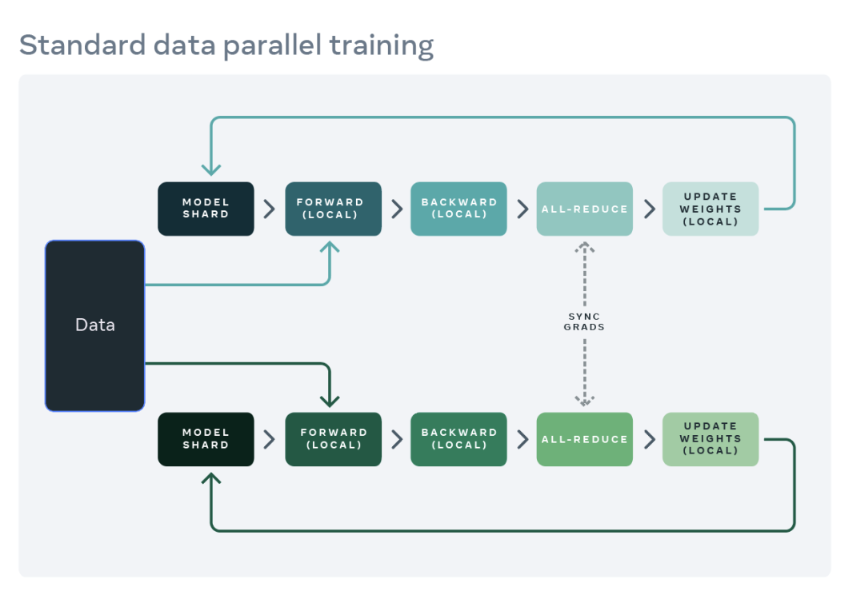

Image: Meta

In [53]:
imgs, classes = next(iter(dl))

imgs = jax.device_put(imgs, P("data", None, None))
classes = jax.device_put(classes, P("data"))

In [54]:
# jax.debug.visualize_array_sharding(imgs)  # visualize_array_sharding works for 1D and 2D
imgs.sharding

NamedSharding(mesh=Mesh('data': 4, axis_types=(Auto,)), spec=PartitionSpec('data', None, None), memory_kind=device)

In [55]:
jax.debug.visualize_array_sharding(imgs[..., 0])
jax.debug.visualize_array_sharding(classes)

         
  GPU 0  
         
         
  GPU 1  
         
         
  GPU 2  
         
         
  GPU 3  
         

  GPU 0    GPU 1    GPU 2    GPU 3  
                                    

In [56]:
rngs = nnx.Rngs(0)
model = MNISTModel(rngs=rngs)
graphdef, state = nnx.split(model)
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(state)

state = jax.device_put(state, P())  # model is replicate in DP

@jax.jit
def train_step(imgs, y, state, opt_state):

  def loss_fn(state, x, y):
    # with sharding constraints instructs the compiler to shard intermediate value across devices
    # this is a hard sharding constraint - the compiler must obey it
    # the compiler attempts to make optimal decisions about sharding
    x = jax.lax.with_sharding_constraint(x, P("data", None, None))
    yp = nnx.merge(graphdef, state)(x)
    y, yp = jax.lax.with_sharding_constraint((y, yp), P("data"))
    # constraint outputs to ensure data parallelism

    return jnp.mean(optax.softmax_cross_entropy_with_integer_labels(yp, y))
    
  with jax.named_scope("forward"):  # for profiling annotations
    loss = loss_fn(state, imgs, y)
  with jax.named_scope("backward"): # for profiling annotations
    gs = jax.grad(loss_fn)(state, imgs, y)
  pred = nnx.merge(graphdef, state)(imgs)
  updates, opt_state = optimizer.update(gs, opt_state)
  state = optax.apply_updates(state, updates)
  return loss, pred, state, opt_state

loss = 2.0014e+02, accuracy 69.380414%: : 201it [00:13, 15.25it/s]                       


Text(0.5, 0, 'Iteration')

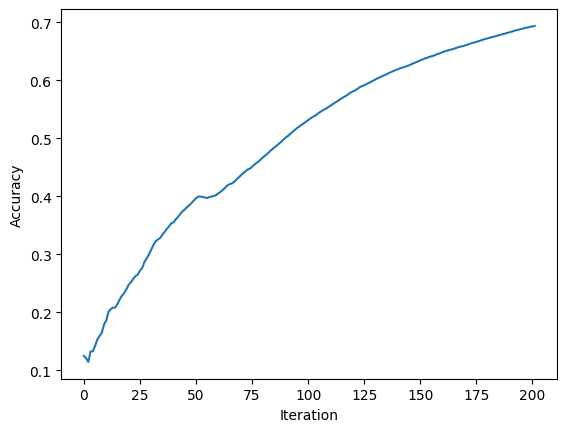

In [57]:
losses = []
max_it = int(2e2)
pbar = tqdm(enumerate(dl), total=max_it)
total, correct = 0, 0
train_accuracies = []
for i, (imgs, classes) in pbar:
  loss, pred, state, opt_state = train_step(imgs, classes, state, opt_state)
  losses.append(loss)
  total, correct = total + imgs.shape[0], correct + jnp.sum(jnp.argmax(pred, -1) == classes)
  train_accuracies.append(correct / total)
  pbar.set_description(f"{loss = :.4e}, accuracy {correct / total:%}")
  if i > max_it:
    break
model = nnx.merge(graphdef, state)  # merge model to insert the optimized state

plt.figure()
plt.plot(train_accuracies)
plt.ylabel("Accuracy")
plt.xlabel("Iteration")

In [67]:
# profile to compare single device vs DP

model = MNISTModel(rngs=rngs)
graphdef, state = nnx.split(model)
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(state)

def profile_body():
  global imgs, classes, state, opt_state
  with use_mesh(jax.make_mesh((1,), ("data",))):
    imgs, classes, state, opt_state  = jax.device_put((imgs, classes, state, opt_state), P())  # place mesh devices
    for _ in range(10):
      loss, pred, state, opt_state = train_step(imgs, classes, state, opt_state)
  with use_mesh(jax.make_mesh((jax.device_count(),), ("data",))):
    imgs, classes, state, opt_state  = jax.device_put((imgs, classes, state, opt_state), P())  # place mesh devices
    for _ in range(10):
      loss, pred, state, opt_state = train_step(imgs, classes, state, opt_state)

profile_body()  # precompile to not profile compilation (cleaner profile)
with jax.profiler.trace(Path("~/profiles").expanduser()):
  profile_body()

2025-04-25 21:09:46.785335: E external/xla/xla/python/profiler/internal/python_hooks.cc:412] Can't import tensorflow.python.profiler.trace
2025-04-25 21:09:48.043035: E external/xla/xla/python/profiler/internal/python_hooks.cc:412] Can't import tensorflow.python.profiler.trace


### FSDP

<!--<img src="images/fsdp.png" style="max-width:800px">-->
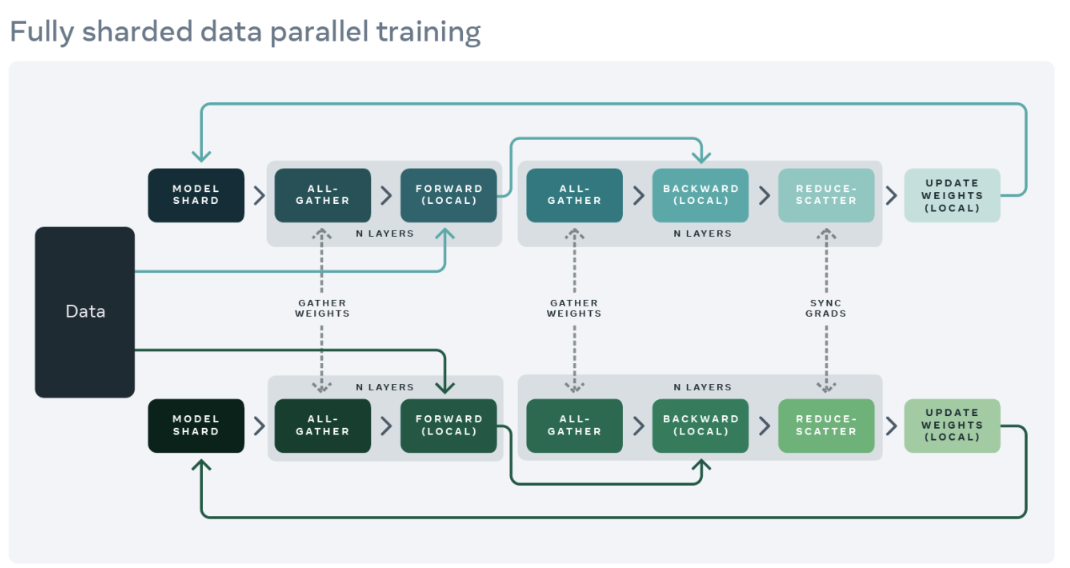

Image: Meta

In [59]:
set_mesh(jax.make_mesh((jax.device_count(),), ("fsdp",)))

def shard_weight(x):
  if x.ndim == 2 and x.shape[0] % mesh.devices.shape[0] == 0:
    return jax.device_put(x, P("fsdp", None))
  else:
    return jax.device_put(x, P())

In [60]:
rngs = nnx.Rngs(0)
model = MNISTModel(rngs=rngs)
graphdef, state = nnx.split(model)
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(state)

# state = jax.device_put(state, P())  # model is replicate in DP
state = jax.tree.map(shard_weight, nnx.state(model))  # for FSDP

@partial(jax.jit, static_argnames=("axis",))
def train_step(imgs, y, state, opt_state, axis=None):

  def loss_fn(state, x, y):
    x = jax.lax.with_sharding_constraint(x, P(axis, None))  # shard data according to `axis` name
    yp = nnx.merge(graphdef, state)(x)
    y, yp = jax.lax.with_sharding_constraint((y, yp), P(axis))  # shard data according to `axis` name
    return jnp.mean(optax.softmax_cross_entropy_with_integer_labels(yp, y))
    
  with jax.named_scope("forward"):  # for profiling annotations
    loss = loss_fn(state, imgs, y)
  with jax.named_scope("backward"): # for profiling annotations
    gs = jax.grad(loss_fn)(state, imgs, y)
  pred = nnx.merge(graphdef, state)(imgs)
  updates, opt_state = optimizer.update(gs, opt_state)
  state = optax.apply_updates(state, updates)
  return loss, pred, state, opt_state

loss = 3.0766e+02, accuracy 71.225244%: : 201it [00:30,  6.67it/s]                       


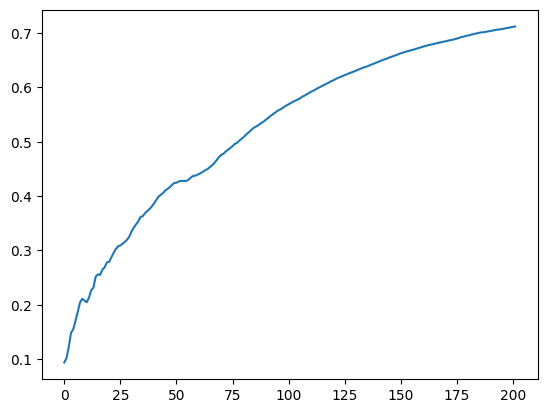

In [61]:
losses = []
max_it = int(2e2)
pbar = tqdm(enumerate(dl), total=max_it)
total, correct = 0, 0
train_accuracies = []
for i, (imgs, classes) in pbar:
  loss, pred, state, opt_state = train_step(imgs, classes, state, opt_state)
  losses.append(loss)
  total, correct = total + imgs.shape[0], correct + jnp.sum(jnp.argmax(pred, -1) == classes)
  train_accuracies.append(correct / total)
  pbar.set_description(f"{loss = :.4e}, accuracy {correct / total:%}")
  if i > max_it:
    break
model = nnx.merge(graphdef, state)  # merge model to insert the optimized state

plt.figure()
plt.plot(train_accuracies)

In [ ]:
# profile to compare single device vs DP vs FSDP
model = MNISTModel(rngs=rngs)
graphdef, state = nnx.split(model)
optimizer = optax.adam(1e-3)

def profile_body():
  global imgs, classes, state

  with use_mesh(jax.make_mesh((1,), ("data",))):
    imgs, classes, state = jax.device_put((imgs, classes, state), P())  # place mesh devices
    opt_state = optimizer.init(state)
    for _ in range(10):
      loss, pred, state, opt_state = train_step(imgs, classes, state, opt_state, axis=None)
  with use_mesh(jax.make_mesh((4,), ("data",))):
    imgs, classes, state = jax.device_put((imgs, classes, state), P())  # place mesh devices
    opt_state = optimizer.init(state)
    for _ in range(10):
      loss, pred, state, opt_state = train_step(imgs, classes, state, opt_state, axis="data")
  with use_mesh(jax.make_mesh((4,), ("fsdp",))):
    imgs, classes, state = jax.device_put((imgs, classes, state), P())  # place mesh devices
    state = jax.tree.map(shard_weight, state)
    opt_state = optimizer.init(state)
    for _ in range(10):
      loss, pred, state, opt_state = train_step(imgs, classes, state, opt_state, axis="fsdp")

profile_body()  # precompile to not profile compilation (cleaner profile)
with jax.profiler.trace(Path("~/profiles").expanduser()):
  profile_body()
  

2025-04-25 21:08:35.374502: E external/xla/xla/python/profiler/internal/python_hooks.cc:412] Can't import tensorflow.python.profiler.trace
2025-04-25 21:08:38.101990: E external/xla/xla/python/profiler/internal/python_hooks.cc:412] Can't import tensorflow.python.profiler.trace


# More useful JAX

### Use multiple CPU devices

In [ ]:
import jax
jax.config.update("jax_num_cpu_devices", 8)
print(jax.devices("cpu"))

### Eval shape - abstract function evaluation

In [73]:
def enormous_array():
  return random.normal(random.key(0), (1024, 1024, 1024, 1024)) # 4 TB
  
A = jax.eval_shape(enormous_array)
print(A.size / 1e9)
A  # just the shape dtype struct

1099.511627776


ShapeDtypeStruct(shape=(1024, 1024, 1024, 1024), dtype=float32)

In [74]:
model = nnx.eval_shape(lambda: MNISTModel(rngs=nnx.Rngs(0)))

### Ahead of time compilation
### [https://openxla.org/](https://openxla.org/)

In [75]:
@jax.jit
def square(x):
  return x ** 2
  
fn = square.lower(jnp.ones(10)).compile()
print(fn.as_text())

HloModule jit_square, is_scheduled=true, entry_computation_layout={(f32[10]{0})->f32[10]{0}}, allow_spmd_sharding_propagation_to_output={true}, num_partitions=4, frontend_attributes={fingerprint_before_lhs="ce93082fa94e2ff761bfe7320f270018"}

%wrapped_multiply_computation (param_0: f32[10]) -> f32[10] {
  %param_0 = f32[10]{0} parameter(0)
  ROOT %multiply.4.1 = f32[10]{0} multiply(%param_0, %param_0), metadata={op_name="jit(square)/jit(main)/integer_pow" source_file="/tmp/ipykernel_67100/3010437327.py" source_line=3}
}

ENTRY %main.3_spmd (param: f32[10]) -> f32[10] {
  %param = f32[10]{0} parameter(0), sharding={replicated}, metadata={op_name="x"}
  ROOT %wrapped_multiply = f32[10]{0} fusion(%param), kind=kLoop, calls=%wrapped_multiply_computation, metadata={op_name="jit(square)/jit(main)/integer_pow" source_file="/tmp/ipykernel_67100/3010437327.py" source_line=3}
}




In [76]:
# works with abstract values, but XLA will warn you about trying to allocate Petabytes of data
fn = square.lower(jax.ShapeDtypeStruct((2 ** 50,), jnp.float32)).compile()
print(fn.as_text())

HloModule jit_square, is_scheduled=true, entry_computation_layout={(f32[1125899906842624]{0})->f32[1125899906842624]{0}}, allow_spmd_sharding_propagation_to_parameters={true}, allow_spmd_sharding_propagation_to_output={true}, num_partitions=4, frontend_attributes={fingerprint_before_lhs="b226c57c56f381dea09c3d21ee0fada6"}

%wrapped_multiply_computation (param_0: f32[1125899906842624]) -> f32[1125899906842624] {
  %param_0 = f32[1125899906842624]{0} parameter(0)
  ROOT %multiply.4.1 = f32[1125899906842624]{0} multiply(%param_0, %param_0), metadata={op_name="jit(square)/jit(main)/integer_pow" source_file="/tmp/ipykernel_67100/3010437327.py" source_line=3}
}

ENTRY %main.3_spmd (param: f32[1125899906842624]) -> f32[1125899906842624] {
  %param = f32[1125899906842624]{0} parameter(0), sharding={replicated}, metadata={op_name="x"}
  ROOT %wrapped_multiply = f32[1125899906842624]{0} fusion(%param), kind=kLoop, calls=%wrapped_multiply_computation, metadata={op_name="jit(square)/jit(main)/inte

2025-04-25 21:10:48.416238: E external/xla/xla/service/gpu/gpu_hlo_schedule.cc:652] The byte size of input/output arguments (9007199254740992) exceeds the base limit (31805177856). This indicates an error in the calculation!
2025-04-25 21:10:48.416455: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3021] Can't reduce memory use below 0B (0 bytes) by rematerialization; only reduced to 4.00PiB (4503599627370496 bytes), down from 4.00PiB (4503599627370496 bytes) originally


In [77]:
train_step_compiled = train_step.lower(imgs, classes, state, opt_state, axis=None).compile()
print(f"Train step is {len(train_step_compiled.as_text().split('\n'))} lines of HLO")

Train step is 5096 lines of HLO


<!--img src="images/escape_hatches.png" style="max-width:800px">-->


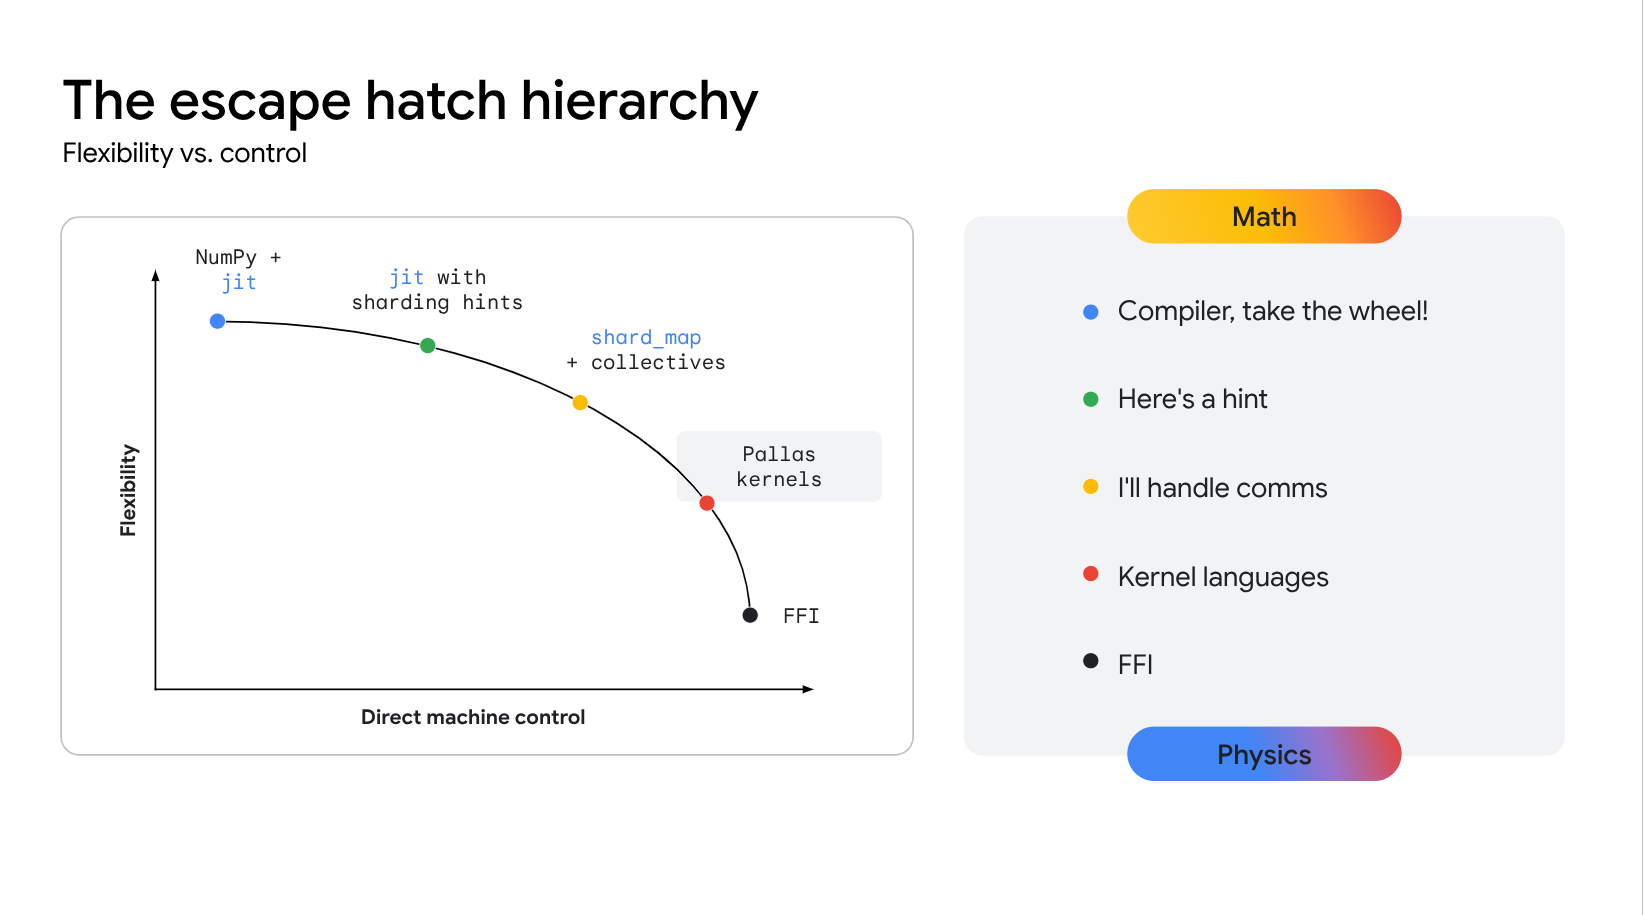

### Explicit Communication: [shard_map](https://docs.jax.dev/en/latest/notebooks/shard_map.html)

In [ ]:
from jax import numpy as jnp
from jax.experimental.shard_map import shard_map


@partial(shard_map, mesh=mesh, 
    in_specs=(P('x', 'y'), P('y', None)),
    out_specs=P('x', None))
def matmul_basic(a_block, b_block):
  # a_block: f32[2, 8]
  # b_block: f32[8, 4]

  # compute
  z_partialsum = jnp.dot(a_block, b_block)

  # communicate
  z_block = jax.lax.psum(z_partialsum, 'y')

  # c_block: f32[2, 4]
  return z_block

### Kernel languages: Pallas

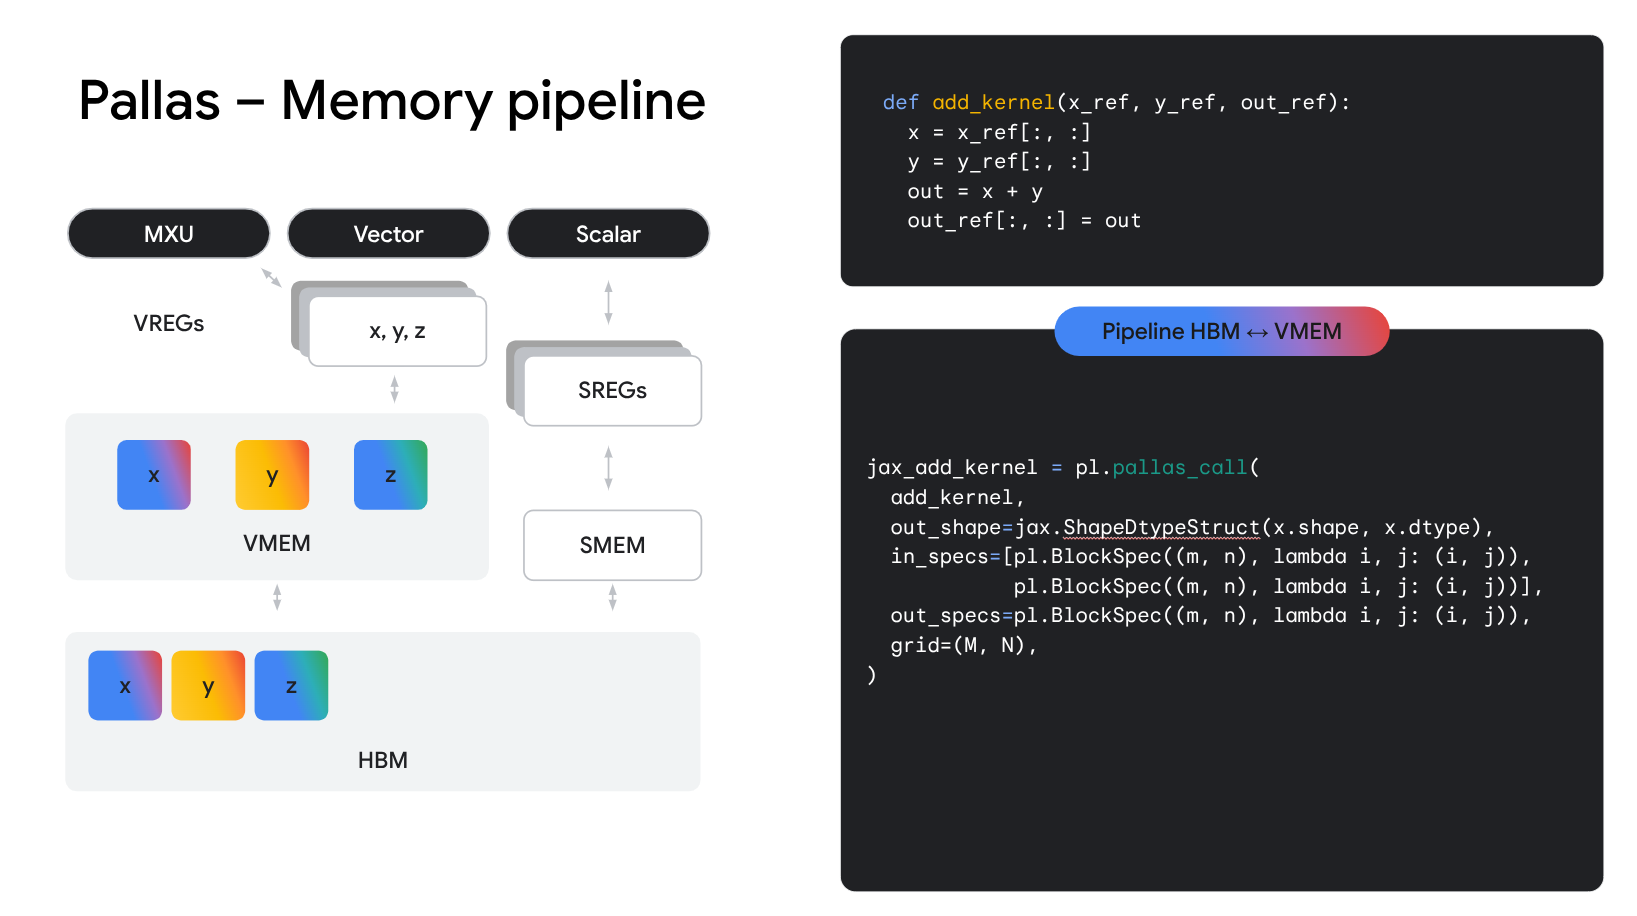

### Advanced checkpointing with Orbax
### [https://github.com/google/orbax](https://github.com/google/orbax)

### MaxText: Production-ready LLMs in JAX
### [https://github.com/ai-Hypercomputer/maxtext/](https://github.com/ai-Hypercomputer/maxtext/)

### High-performance LLM inference
### [https://github.com/jax-ml/jax-llm-examples](https://github.com/jax-ml/jax-llm-examples)